In [1]:
import importlib

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm

from Utils import common_functions
from Utils import paths
from Utils import plot_utils
from Utils import transformation_utils as t_utils

importlib.reload(plot_utils)
importlib.reload(common_functions)

<module 'Utils.common_functions' from 'C:\\Users\\jllav\\IdeaProjects\\TFM\\Utils\\common_functions.py'>

In [2]:
clinical_ph = pd.read_pickle(f"{paths.ORIGINAL_DATA_PATH}/clinical_ctu-chb.pickle")['ph']
clinical_ph

1001    7.14
1002    7.00
1003    7.20
1004    7.30
1005    7.30
        ... 
2042    7.33
2043    7.08
2044    7.02
2045    7.03
2046    7.01
Name: ph, Length: 552, dtype: float64

In [3]:
# .apply(lambda x: 0 if x >= 7.2 else 1)
# >= 7.2 normal // < 7.2 patologico
clinical_ph_0 = clinical_ph[clinical_ph >= 7.2]
clinical_ph_1 = clinical_ph[clinical_ph < 7.2]

clinical_ph_0.shape, clinical_ph_1.shape

((375,), (177,))

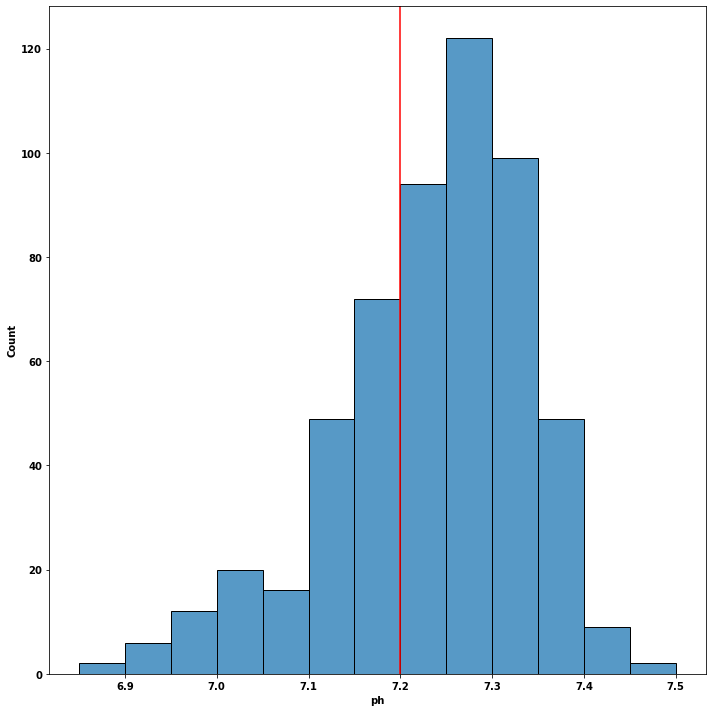

In [4]:
fig, ax = plt.subplots(1,  1, figsize=(10, 10))
sns.histplot(clinical_ph, binwidth=0.05, ax=ax)
ax.axvline(7.2, color='red')
fig.tight_layout()

In [5]:
prop_0 = clinical_ph_0.shape[0] / clinical_ph.shape[0]
prop_1 = clinical_ph_1.shape[0] / clinical_ph.shape[0]

prop_0, prop_1

(0.6793478260869565, 0.32065217391304346)

(7.18, 7.22)

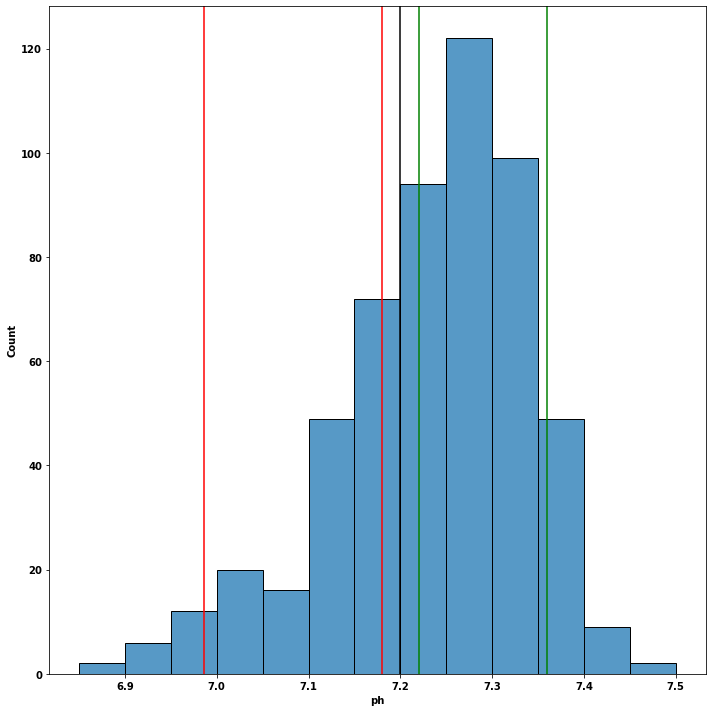

In [6]:
fig, ax = plt.subplots(1,  1, figsize=(10, 10))
sns.histplot(clinical_ph, binwidth=0.05, ax=ax)
ax.axvline(clinical_ph_0.quantile(0.1), color='green')
ax.axvline(clinical_ph_0.quantile(0.9), color='green')
ax.axvline(clinical_ph_1.quantile(0.9), color='red')
ax.axvline(clinical_ph_1.quantile(0.1), color='red')
ax.axvline(7.2, color='black')
fig.tight_layout()

clinical_ph_1.quantile(0.9), clinical_ph_0.quantile(0.1)

In [11]:
removed = clinical_ph_1[clinical_ph_1 >= 7.15]
# removed.shape[0] / clinical_ph.shape[0]
removed

1007    7.16
1009    7.18
1019    7.15
1030    7.16
1040    7.17
        ... 
1486    7.19
1491    7.16
1501    7.16
2020    7.15
2028    7.18
Name: ph, Length: 72, dtype: float64

In [13]:
before_dismissed = [1104, 1119, 1134, 1149, 1155, 1158, 1186, 1188, 1258, 1292, 1322,
                    1327, 1451, 1477, 1482, 2003]

filtered_3030 = [1025, 1026, 1027, 1029, 1030, 1031, 1033, 1034, 1037, 1039, 1041,
                 1042, 1043, 1044, 2039, 1046, 1047, 1049, 1050, 1051, 1052, 1054,
                 1056, 1057, 1058, 1059, 1062, 1063, 1065, 1068, 1069, 1071, 1072,
                 1073, 1074, 1075, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1087,
                 1088, 1089, 1090, 1091, 1093, 1095, 1099, 1100, 1101, 1104, 1105,
                 1107, 1108, 1111, 1114, 1115, 1117, 1119, 1121, 1122, 1125, 1126,
                 1128, 1130, 1131, 1133, 1134, 1137, 1138, 1140, 1145, 1146, 1149,
                 1150, 1151, 1154, 1155, 1156, 1158, 1160, 1164, 1168, 1170, 1171,
                 1173, 1174, 1175, 1178, 1181, 1184, 1186, 1187, 1188, 1194, 1196,
                 1198, 1199, 1200, 1203, 1205, 1206, 1209, 1211, 1212, 1213, 1214,
                 1215, 1216, 1217, 1219, 1220, 1222, 1227, 1228, 1231, 1232, 1233,
                 1239, 1242, 1243, 1244, 1245, 1246, 1247, 1250, 1251, 1252, 1253,
                 1254, 1255, 1257, 1258, 1259, 1260, 1261, 1262, 1265, 1266, 1267,
                 1268, 1271, 1272, 1274, 1275, 1276, 1277, 1279, 1283, 1284, 1289,
                 1290, 1291, 1292, 1296, 1297, 1298, 1300, 1302, 1304, 1306, 1307,
                 1310, 1311, 1312, 1313, 1316, 1318, 1321, 1322, 1323, 1324, 1325,
                 1327, 1329, 1330, 1333, 1335, 1336, 1338, 1347, 1348, 1351, 1353,
                 1354, 1355, 1357, 1358, 1359, 1360, 1361, 1363, 1364, 1365, 1369,
                 1371, 1374, 1375, 1376, 1377, 1383, 1384, 1386, 1388, 1390, 1391,
                 1392, 1393, 1394, 1397, 1398, 1404, 1406, 1407, 1409, 1410, 1411,
                 1414, 1417, 1419, 1422, 1424, 1425, 1431, 1433, 1434, 1437, 1441,
                 1444, 1448, 1449, 1451, 1455, 1456, 1458, 1462, 1463, 1465, 1469,
                 1470, 1474, 1475, 1477, 1478, 1479, 1480, 1481, 1482, 1483, 1488,
                 1489, 1491, 1492, 1493, 1494, 2003, 2004, 2008, 2010, 2011, 2012,
                 1501, 2013, 1503, 1505, 2019, 2020, 2021, 2022, 2024, 1001, 1002,
                 1003, 1004, 1005, 1006, 1007, 2026, 1009, 1010, 2028, 2033, 1013,
                 1014, 1015, 1016, 1017, 2035, 1019, 2036, 1021, 2046]

In [14]:
removed_index = removed.index.to_list()
removed_index = set(removed_index).union(set(before_dismissed))
removed_index = set(removed_index).union(set(filtered_3030))
removed_index = np.array(list(removed_index))
removed_index.shape

(320,)

In [15]:
fhr = pd.read_pickle(f"{paths.CLEAN_DATA_PATH}/fhr.pickle")
uc = pd.read_pickle(f"{paths.CLEAN_DATA_PATH}/uc.pickle")
y = pd.read_pickle(f"{paths.CLEAN_DATA_PATH}/y.pickle")

fhr.shape, uc.shape, y.shape

((552, 21620), (552, 21620), (552,))

In [16]:
clean_fhr = fhr.drop(removed_index)
clean_uc = uc.drop(removed_index)
y_clean = y.drop(removed_index)
clean_fhr.shape, clean_uc.shape, y_clean.shape

((232, 21620), (232, 21620), (232,))

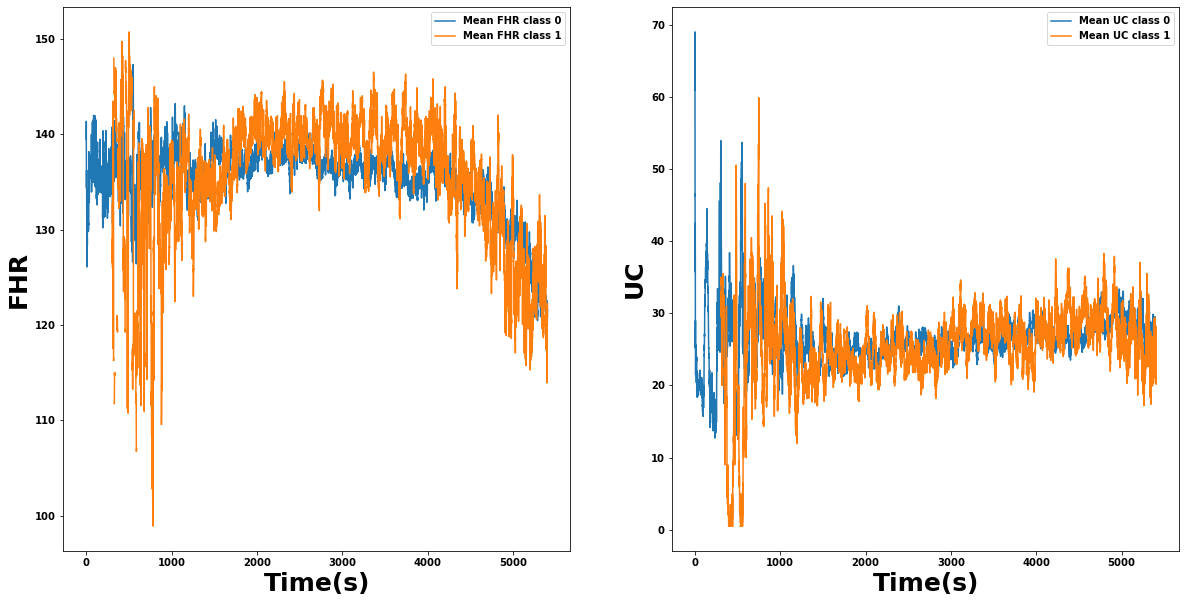

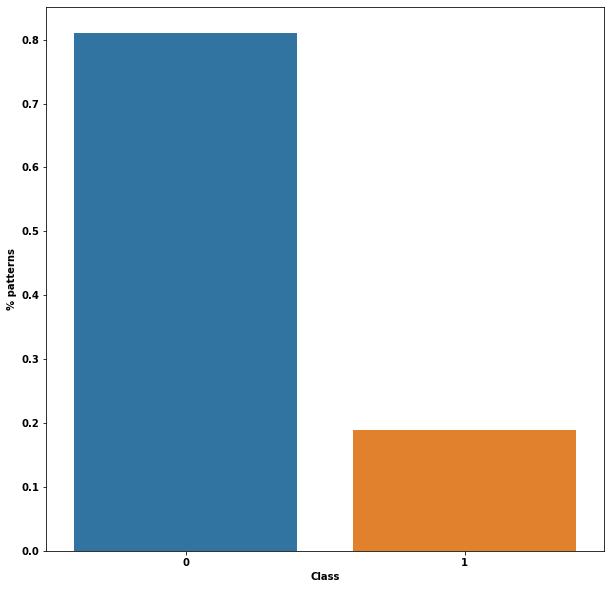

In [17]:
plot_utils.plot_fhr_uc(clean_fhr, clean_uc, y_clean)
plot_utils.plot_class_proportion(y_clean)

In [18]:
cc_data = dict()
lags = t_utils.calc_lags(minutes=5)

for (idx_fhr, fhr_row), (idx_uc, uc_row) in tqdm(zip(clean_fhr.copy().iterrows(), clean_uc.copy().iterrows()), total=len(clean_uc)):
    fhr_signal = pd.Series(fhr_row.values)
    uc_signal = pd.Series(uc_row.values)

    cc_data[idx_fhr] = joblib.Parallel(n_jobs=8)(
        joblib.delayed(t_utils.cc)(fhr_signal, uc_signal, lag, 3000) for lag in lags
    )
cc_df = pd.DataFrame(cc_data).T
cc_df.columns = lags
cc_df

  0%|          | 0/232 [00:00<?, ?it/s]

,-1199,-1198,-1197,-1196,-1195,-1194,-1193,-1192,-1191,-1190,...,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199
1008,-0.083502,-0.084149,-0.084732,-0.085223,-0.085468,-0.085481,-0.085528,-0.085612,-0.085485,-0.085149,...,-0.215721,-0.214717,-0.213588,-0.212825,-0.212050,-0.211297,-0.210491,-0.209843,-0.209250,-0.208866
1011,-0.133849,-0.134487,-0.134968,-0.135571,-0.135782,-0.135579,-0.134966,-0.134359,-0.133537,-0.132680,...,-0.268713,-0.266977,-0.265421,-0.263665,-0.262000,-0.260370,-0.258714,-0.257224,-0.255627,-0.254546
1012,-0.111098,-0.111617,-0.112126,-0.112513,-0.112868,-0.113153,-0.113625,-0.114078,-0.114843,-0.115583,...,-0.096819,-0.097509,-0.098398,-0.099303,-0.100388,-0.101318,-0.102387,-0.103120,-0.103671,-0.103962
1018,-0.005741,-0.004651,-0.003515,-0.002268,-0.001373,-0.000241,0.000804,0.001672,0.002500,0.003367,...,-0.106092,-0.106148,-0.105840,-0.105664,-0.105280,-0.105044,-0.105192,-0.105457,-0.105363,-0.105257
1020,-0.107180,-0.108969,-0.110797,-0.112510,-0.114100,-0.115577,-0.116908,-0.118414,-0.119681,-0.121094,...,-0.064437,-0.066065,-0.067244,-0.067815,-0.068931,-0.070190,-0.071928,-0.074225,-0.076111,-0.078363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2041,0.006330,0.005324,0.004203,0.002887,0.001586,0.000399,-0.000863,-0.002248,-0.003795,-0.005521,...,0.033055,0.032924,0.032829,0.032727,0.032663,0.032644,0.032638,0.032696,0.032828,0.032975
2042,-0.079467,-0.077935,-0.076384,-0.074798,-0.073322,-0.071966,-0.070564,-0.069252,-0.067818,-0.066883,...,-0.209855,-0.210246,-0.210503,-0.211309,-0.211807,-0.212266,-0.213027,-0.213783,-0.214986,-0.215639
2043,0.007374,0.006142,0.004517,0.002829,0.001037,-0.000626,-0.001970,-0.002984,-0.004611,-0.006215,...,-0.178921,-0.178776,-0.178597,-0.178450,-0.177884,-0.177448,-0.176855,-0.176449,-0.175893,-0.175490
2044,0.009746,0.009735,0.009070,0.008440,0.007824,0.007105,0.006719,0.005917,0.005915,0.006205,...,0.157561,0.158602,0.159348,0.160350,0.160821,0.161080,0.161083,0.160907,0.161083,0.161616


In [19]:
bad_idx = cc_df.index[cc_df.isna().sum(axis=1) != 0]
bad_idx

Int64Index([], dtype='int64')

In [20]:
cc_df = cc_df.drop(bad_idx, errors='ignore')
tt = np.array(lags)
cc_df.shape, y_clean.shape

((232, 2399), (232,))

In [21]:
cdcor_data = dict()
lags = t_utils.calc_lags(minutes=5)

for (idx_fhr, fhr_row), (idx_uc, uc_row) in tqdm(zip(clean_fhr.copy().iterrows(), clean_uc.copy().iterrows()), total=len(clean_uc)):
    fhr_signal = pd.Series(fhr_row.values)
    uc_signal = pd.Series(uc_row.values)

    cdcor_data[idx_fhr] = joblib.Parallel(n_jobs=8)(
        joblib.delayed(t_utils.dcor)(fhr_signal, uc_signal.shift(lag), 3000)
        for lag in lags
    )
cdcor_df = pd.DataFrame(cdcor_data).T
cdcor_df.columns = lags
cdcor_df

  0%|          | 0/232 [00:00<?, ?it/s]

,-1199,-1198,-1197,-1196,-1195,-1194,-1193,-1192,-1191,-1190,...,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199
1008,0.141507,0.141427,0.141413,0.141424,0.141275,0.141038,0.140875,0.140794,0.140510,0.140047,...,0.204428,0.203778,0.202931,0.202411,0.201936,0.201502,0.200920,0.200456,0.200110,0.199870
1011,0.181189,0.180793,0.180487,0.180315,0.180072,0.179741,0.179307,0.178897,0.178282,0.177485,...,0.259096,0.258626,0.258112,0.257653,0.257263,0.256896,0.256586,0.256334,0.256161,0.255926
1012,0.173518,0.173562,0.173906,0.174242,0.174456,0.174477,0.174584,0.175010,0.175506,0.176088,...,0.124768,0.124813,0.125023,0.125321,0.125719,0.126206,0.126611,0.126879,0.127184,0.127425
1018,0.103245,0.103418,0.103561,0.103778,0.104015,0.103842,0.103492,0.103465,0.103282,0.103275,...,0.121771,0.121970,0.122042,0.122402,0.122671,0.123001,0.123618,0.124277,0.124605,0.124878
1020,0.136781,0.137997,0.139330,0.140464,0.141462,0.142417,0.143334,0.144358,0.145217,0.146167,...,0.194933,0.195345,0.195832,0.196175,0.196535,0.196967,0.197588,0.198337,0.199214,0.200169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2041,0.133774,0.133501,0.133212,0.133083,0.132991,0.132763,0.132621,0.132489,0.132502,0.132675,...,0.113226,0.112584,0.111965,0.111299,0.110548,0.109801,0.109195,0.108638,0.108109,0.107779
2042,0.131818,0.131582,0.131271,0.130819,0.130369,0.130064,0.129818,0.129748,0.129833,0.130096,...,0.237502,0.238429,0.239330,0.240515,0.241493,0.242233,0.243234,0.244157,0.245192,0.246006
2043,0.110304,0.110701,0.111004,0.110785,0.110925,0.111393,0.112049,0.112842,0.113590,0.114025,...,0.290978,0.290896,0.290442,0.289885,0.289018,0.288247,0.287252,0.286135,0.284944,0.283996
2044,0.146177,0.146335,0.146558,0.146824,0.146973,0.147125,0.147307,0.147527,0.147622,0.147567,...,0.224921,0.224977,0.224839,0.224642,0.224270,0.223962,0.223642,0.223450,0.223216,0.222841


In [22]:
bad_idx = cdcor_df.index[cdcor_df.isna().sum(axis=1) != 0]
bad_idx

Int64Index([], dtype='int64')

In [23]:
cdcor_df = cdcor_df.drop(bad_idx, errors='ignore')
tt = np.array(lags)
cdcor_df.shape, y_clean.shape

((232, 2399), (232,))

In [24]:
fft_data = dict()
freqs = t_utils.get_freqs(fhr.shape[-1])

for idx_fhr, fhr_row in tqdm(clean_fhr.copy().iterrows(), total=len(clean_fhr)):
    fhr_signal = fhr_row.values

    fft_data[idx_fhr] = t_utils.nan_save_fft(fhr_signal, freqs)

  0%|          | 0/232 [00:00<?, ?it/s]

In [25]:
fft_df = pd.DataFrame(fft_data).T
fft_df.columns = freqs
fft_df = fft_df.loc[:, freqs <= 0.1]
fft_df = fft_df.iloc[:, 1:]
freqs = np.array(freqs)[freqs <= 0.1][1:]
fft_df

,0.000185,0.000370,0.000555,0.000740,0.000925,0.001110,0.001295,0.001480,0.001665,0.001850,...,0.098242,0.098427,0.098612,0.098797,0.098982,0.099167,0.099352,0.099537,0.099722,0.099907
1008,6.697466e+05,5.842853e+05,327576.670211,96667.506480,145179.940490,184288.014092,161911.912292,39543.505872,20499.688559,142956.342652,...,33367.781245,12166.946330,20944.384118,4980.571813,25206.457559,16645.304701,11097.838439,11245.381034,4502.600802,14252.660072
1011,9.608563e+05,5.206807e+05,275572.257374,287320.313868,327156.787018,219909.935506,155298.031421,87806.588190,30970.122201,89439.057837,...,5931.388001,6130.076495,2826.703384,818.436308,6476.065431,5779.941758,12001.907098,10877.929011,9422.032318,12548.272552
1012,5.231348e+05,1.285136e+06,480281.494331,272601.252180,104066.634044,120178.244745,121984.482636,216392.338501,243484.743959,123852.024306,...,6906.160770,8491.018234,19086.947033,4252.823846,11228.061626,8269.715288,4562.192927,1866.106754,8299.155996,7251.380005
1018,1.155695e+06,7.780471e+05,536999.401997,444634.896729,251345.696267,320439.102855,68974.538228,356620.221395,130795.636078,107669.461238,...,11321.160187,11795.697638,18962.286049,38496.447349,29217.320220,34073.872689,10362.883943,32830.714438,22704.389346,26335.053905
1020,9.127834e+05,6.291472e+05,324888.097694,84380.391767,83572.336334,152971.951211,153538.983466,115466.702727,26793.917202,76975.540642,...,7277.426879,10312.044132,1760.626646,7625.160656,5893.412158,8301.742732,6479.727385,7339.435622,12194.637904,10055.868107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2041,1.360081e+06,7.121760e+05,29826.749387,331773.689152,278366.259607,48589.176923,207932.837283,170987.369303,16788.475687,152283.130332,...,10521.304595,3873.620745,5745.238678,6278.818335,9110.764010,7452.837924,5965.946568,13787.328042,7076.264797,1914.586368
2042,1.113381e+06,5.833392e+05,34863.576885,304637.367072,238602.887594,38188.515685,176367.628728,151442.274934,43097.481274,126291.141105,...,7780.356365,2893.632444,1620.945887,3334.664223,3285.460752,4247.097505,3438.509811,6947.748183,9955.652788,10631.677496
2043,6.354950e+05,5.508237e+05,418518.851728,260158.286454,309211.328105,181059.616083,121957.114262,187818.661390,37404.570670,253064.639584,...,14337.236895,4607.442143,9173.857815,8823.195893,15249.646648,11056.069116,1672.288258,4081.077702,12735.470130,9403.181577
2044,1.353436e+06,7.243038e+05,57644.239917,363790.725783,290057.641381,33268.903643,215035.739114,147605.482310,30046.118843,131281.026743,...,3591.598836,2793.073099,2734.294538,2598.577669,4482.027638,361.447820,2296.427635,6908.955743,2428.634050,8209.963495


In [26]:
cc_df.to_csv(f"{paths.CC_DATA_PATH}/new_easy_cc_dataset.csv")
cc_df['patologico'] = y_clean
X = cc_df.iloc[:, :-1]
X.to_pickle(f"{paths.CC_DATA_PATH}/new_easy_X.pickle")
y_clean.to_pickle(f"{paths.CC_DATA_PATH}/new_easy_y.pickle")

In [27]:
cdcor_df.to_csv(f"{paths.CDCOR_DATA_PATH}/new_easy_cdcor_dataset.csv")
cdcor_df['patologico'] = y_clean
X = cdcor_df.iloc[:, :-1]
X.to_pickle(f"{paths.CDCOR_DATA_PATH}/new_easy_X.pickle")
y_clean.to_pickle(f"{paths.CDCOR_DATA_PATH}/new_easy_y.pickle")

In [28]:
fft_df.to_csv(f"{paths.FFT_DATA_PATH}/new_easy_fft_dataset.csv")
fft_df['patologico'] = y_clean
X = fft_df.iloc[:, :-1]
X.to_pickle(f"{paths.FFT_DATA_PATH}/new_easy_X.pickle")
y_clean.to_pickle(f"{paths.FFT_DATA_PATH}/new_easy_y.pickle")

In [29]:
y_clean = pd.read_pickle(f"{paths.CC_DATA_PATH}/new_easy_y.pickle")

cc_df = pd.read_csv(f"{paths.CC_DATA_PATH}/new_easy_cc_dataset.csv", index_col=0)
cdcor_df = pd.read_csv(f"{paths.CDCOR_DATA_PATH}/new_easy_cdcor_dataset.csv", index_col=0)
fft_df = pd.read_csv(f"{paths.FFT_DATA_PATH}/new_easy_fft_dataset.csv", index_col=0)

tt = cc_df.columns.astype('int')
freqs = fft_df.columns.astype('float64')

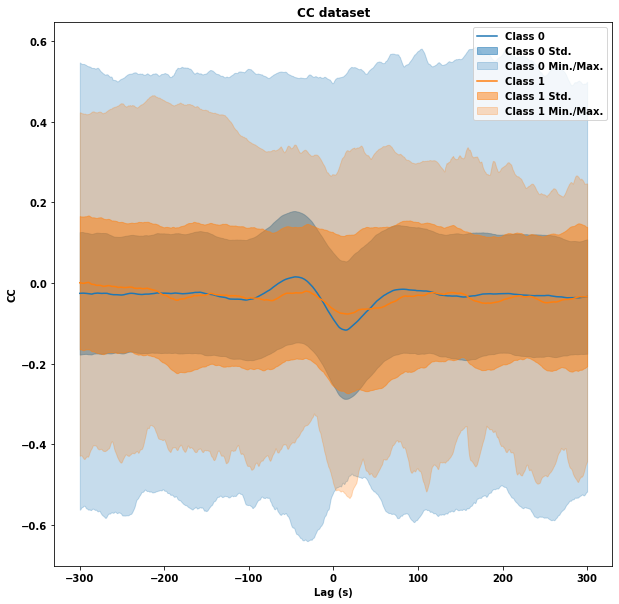

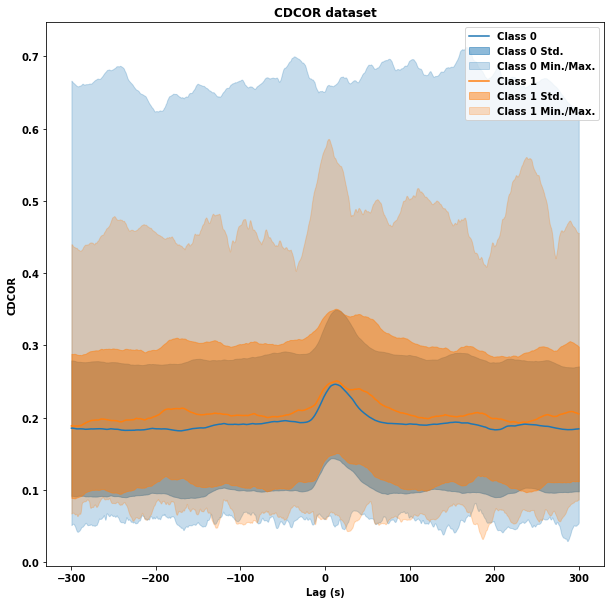

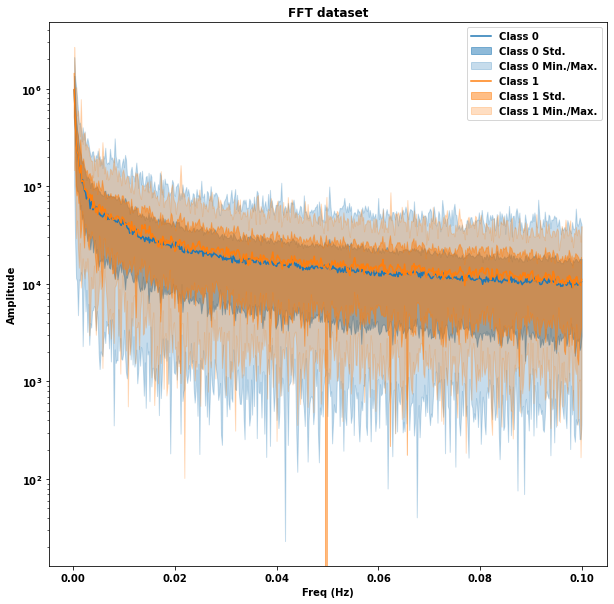

In [30]:
plot_utils.plot_data_desc(tt, cc_df, y_clean, f'CC dataset', 'CC')
plot_utils.plot_data_desc(tt, cdcor_df, y_clean, f'CDCOR dataset', 'CDCOR')
plot_utils.plot_data_desc(freqs, fft_df, y_clean, f'FFT dataset', 'Amplitude', fourier=True)
#

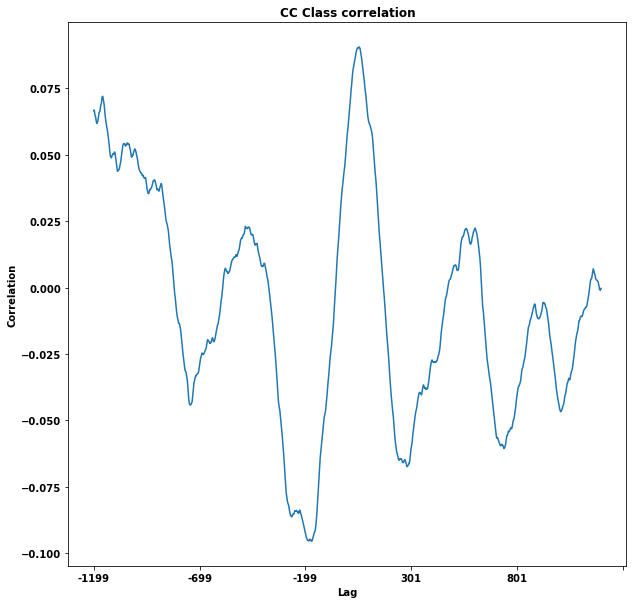

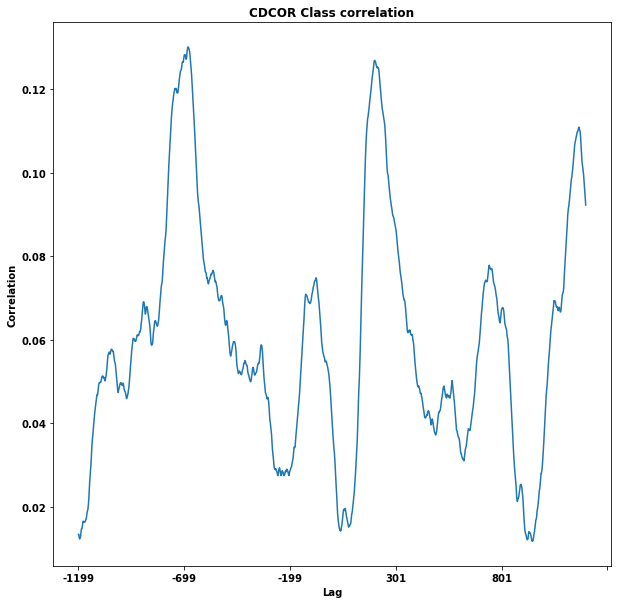

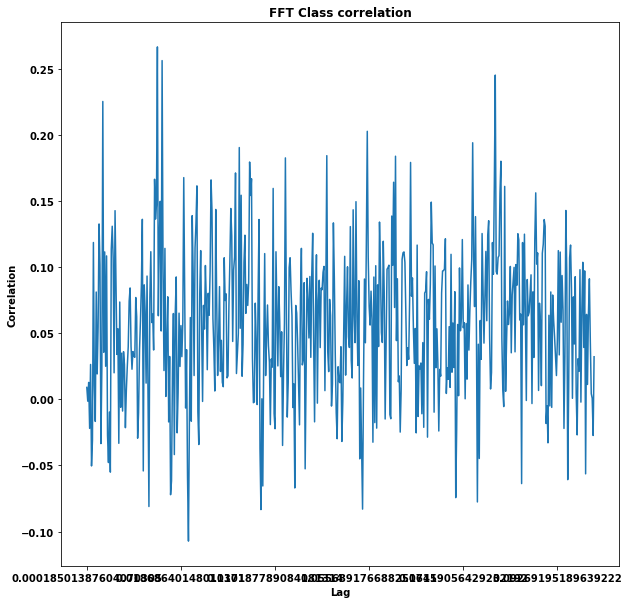

In [31]:
plot_utils.plot_class_correlation(cc_df, y_clean, title=f'CC Class correlation')
plot_utils.plot_class_correlation(cdcor_df, y_clean, title=f'CDCOR Class correlation')
plot_utils.plot_class_correlation(fft_df, y_clean, title=f'FFT Class correlation')

  0%|          | 0/2399 [00:00<?, ?it/s]

  0%|          | 0/2399 [00:00<?, ?it/s]

  0%|          | 0/540 [00:00<?, ?it/s]

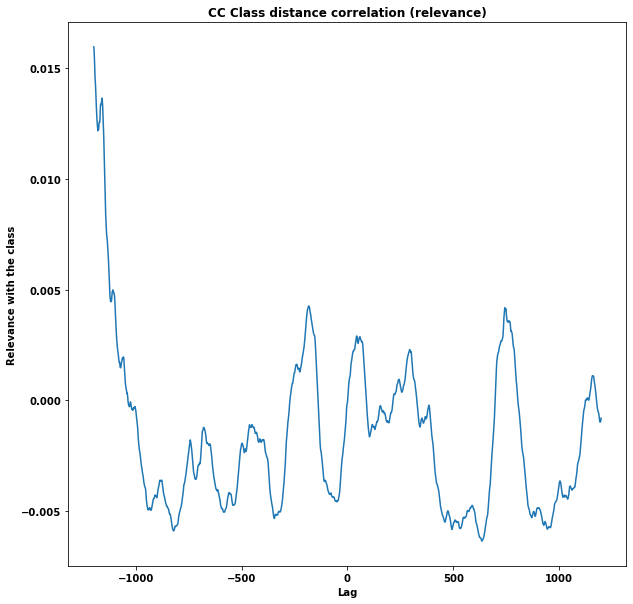

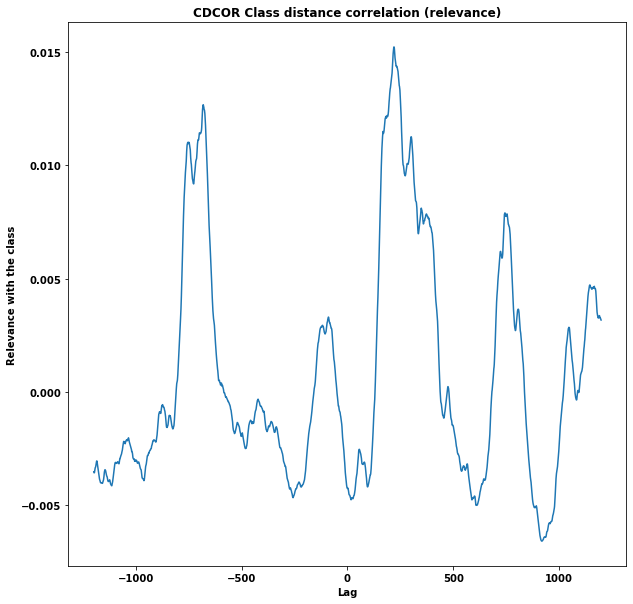

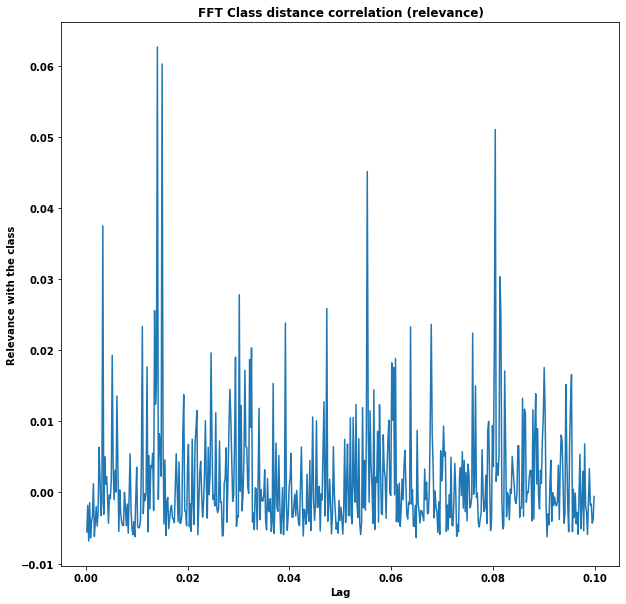

In [32]:
plot_utils.plot_relevance(cc_df, y_clean, title=f'CC Class distance correlation (relevance)')
plot_utils.plot_relevance(cdcor_df, y_clean, title=f'CDCOR Class distance correlation (relevance)')
plot_utils.plot_relevance(fft_df, y_clean, title=f'FFT Class distance correlation (relevance)')

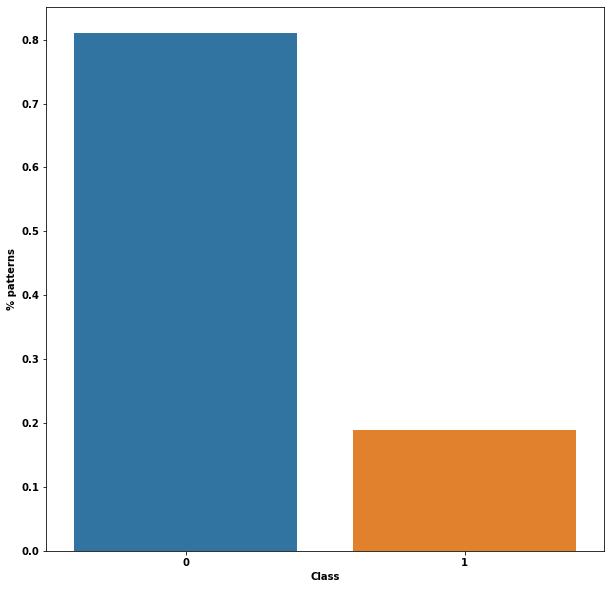

In [33]:
plot_utils.plot_class_proportion(y_clean)